# Clusterización y regionalización

In [36]:
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn 
import pandas
import geopandas 
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 5
pandas.set_option('display.max_columns', None)

## Introducción 

Las preguntas más difíciles del mundo son complejas y multifacéticas. Los métodos eficaces para aprender de los datos deben reconocer esto. **Muchas preguntas y desafíos son intrínsecamente multidimensionales**; se ven afectados, moldeados y definidos por muchos componentes diferentes que actúan simultáneamente. En términos estadísticos, estos procesos se denominan **procesos multivariados**, en contraposición a procesos univariados., donde solo una variable actúa a la vez. **La agrupación en clústeres** es un método fundamental de análisis geográfico que extrae conocimientos de procesos multivariados grandes y complejos. Funciona al encontrar **similitudes entre las muchas dimensiones en un proceso multivariado, condensándolas en una representación más simple.** Así, a través de la agrupación, un proceso complejo y difícil de entender se transforma en uno más simple que incluso las audiencias no técnicas pueden ver y comprender. .

A menudo, la agrupación implica clasificar las observaciones en grupos. Para que estos grupos sean más significativos que cualquier dimensión inicial única, los miembros de un grupo deben ser más similares entre sí que a los miembros de un grupo diferente. Cada grupo se conoce como un clúster, mientras que el proceso de asignación de objetos a los grupos se conoce como agrupamiento . Si se hace bien, estos grupos se pueden caracterizar por su perfil , un resumen simple de cómo son los miembros de un grupo en términos del proceso multivariado original.

Dado que un buen conglomerado es más similar internamente que a cualquier otro conglomerado, estos perfiles a nivel de conglomerado proporcionan una forma abreviada de describir el complejo proceso multivariado original. Las observaciones en un grupo pueden tener puntuaciones altas en algunos rasgos, pero puntuaciones bajas en otros. **El analista solo necesita mirar el perfil de un grupo para tener una buena idea de cómo son todas las observaciones en ese grupo, en lugar de tener que considerar todas las complejidades del proceso multivariado original a la vez.** En toda la ciencia de datos, y particularmente en la ciencia de datos geográficos, la agrupación en clústeres se usa ampliamente para proporcionar información sobre la estructura geográfica de datos espaciales multivariados complejos.

**En el contexto de cuestiones explícitamente espaciales, un concepto relacionado, la región , también es instrumental**. Una región es similar a un clúster , en el sentido de que todos los miembros de una región se han agrupado y la región debe proporcionar una abreviatura de los datos originales. Además, para que una región sea analíticamente útil, sus miembros también deben mostrar una mayor similitud entre sí que con los miembros de otras regiones. **Sin embargo, las regiones son más complejas que los clústeres porque combinan esta similitud de perfil con información adicional sobre la geografía de sus miembros**. En resumen, las regiones son como conglomerados (ya que tienen un perfil coherente), pero también tienen una geografía coherente: los miembros de una región también deben ubicarse cerca unos de otros.

**El proceso de creación de regiones se llama regionalización**. Una regionalización es un tipo especial de agrupamiento en el que el objetivo es **agrupar observaciones que son similares en sus atributos estadísticos, pero también en su ubicación espacial**. En este sentido, la regionalización incorpora la misma lógica que las técnicas de agrupamiento estándar, pero también **aplica una serie de restricciones espaciales y / o geográficas**. A menudo, estas restricciones se relacionan con la **conectividad**: dos candidatos solo se pueden agrupar en la misma región si existe una ruta de un miembro a otro que nunca abandona la región. Estas rutas a menudo modelan las relaciones espaciales en los datos, como la contigüidad o la proximidad. **Sin embargo, no siempre es necesario que la conectividad sea válida para todas las regiones.**

En este capítulo consideramos las técnicas de agrupamiento y los métodos de regionalización que nos permitirán hacer exactamente eso. En el proceso, exploraremos las características de los vecindarios de San Diego. Extraeremos patrones comunes de la nube de datos multidimensionales que la Oficina del Censo produce sobre áreas pequeñas a través de la Encuesta de la Comunidad Estadounidense. Comenzamos con una exploración de los datos multivariados sobre San Diego sugiriendo algunas formas de examinar la distribución estadística y espacial de los datos antes de realizar cualquier agrupación. Centrarse en las variables individuales, así como en sus asociaciones por pares, puede ayudar a guiar la aplicación posterior de agrupaciones o regionalizaciones.

Luego consideramos los enfoques geodemográficos para la agrupación: la aplicación de la agrupación multivariada a los datos demográficos referenciados espacialmente. Se emplean dos algoritmos de agrupamiento populares: **k-means** y el **método jerárquico de Ward**. El mapeo de la distribución espacial de los conglomerados resultantes revela ideas interesantes sobre la estructura socioeconómica del área metropolitana de San Diego. También vemos que **en muchos casos, los clústeres están fragmentados espacialmente**. Es decir, un clúster puede constar de diferentes áreas que no están conectadas espacialmente. De hecho, algunos grupos tendrán sus miembros esparcidos por todo el mapa. Esto ilustrará por qué **la conectividad podría ser importante al generar información sobre datos espaciales, ya que estos grupos no proporcionarán regiones inteligibles. Entonces, pasaremos a la regionalización,****

## Datos 

El conjunto de datos que usaremos en este capítulo proviene de la Encuesta sobre la Comunidad Estadounidense (ACS). En particular, examinamos los datos a nivel de zona censal en San Diego, California en 2017. Comencemos leyendo los datos como un GeoDataFrame y explorando los nombres de los atributos.

In [4]:
# Read file
db = geopandas.read_file('./data/sandiego_tracts.gpkg')
# Print column names
db.columns

Index(['GEOID', 'median_age', 'total_pop', 'total_pop_white', 'tt_work',
       'hh_total', 'hh_female', 'total_bachelor', 'median_hh_income',
       'income_gini', 'total_housing_units', 'total_rented', 'median_no_rooms',
       'median_house_value', 'NAME', 'state', 'county', 'tract', 'area_sqm',
       'pct_rented', 'pct_hh_female', 'pct_bachelor', 'pct_white', 'sub_30',
       'geometry'],
      dtype='object')

In [13]:
print('Nº de filas / columnas:',db.shape)
db.head(2)

Nº de filas / columnas: (628, 25)


,GEOID,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,total_housing_units,total_rented,median_no_rooms,median_house_value,NAME,state,county,tract,area_sqm,pct_rented,pct_hh_female,pct_bachelor,pct_white,sub_30,geometry
0,06073018300,37.1,2590.0,2375.0,1299.0,2590.0,137.0,0.0,62500.0,0.5355,2530.0,946.0,3.9,732900.0,"Census Tract 183, San Diego County, California",06,073,018300,2.876449,0.373913,0.052896,0.000000,0.916988,False,"POLYGON ((-13069450.120 3922380.770, -13069175..."
1,06073018601,41.2,5147.0,4069.0,1970.0,5147.0,562.0,24.0,88165.0,0.4265,1633.0,335.0,6.5,473800.0,"Census Tract 186.01, San Diego County, California",06,073,018601,4.548797,0.205144,0.109190,0.004663,0.790558,False,"POLYGON ((-13067719.770 3922939.420, -13067631..."


Para facilitar las cosas más adelante, recopilemos las variables que usaremos para caracterizar las secciones censales. Estas variables capturan diferentes aspectos de la realidad socioeconómica de cada área y, en conjunto, brindan una caracterización integral de San Diego en su conjunto:

In [15]:
cluster_variables =  [
    'median_house_value', # Median house value
    'pct_white',          # Percent of tract population that is white
    'pct_rented',         # Percent of households that are rented
    'pct_hh_female',      # Percent of female-led households 
    'pct_bachelor',       # Percent of tract population with a Bachelors degree
    'median_no_rooms',    # Median number of rooms in the tract's households
    'income_gini',        # Gini index measuring tract wealth inequality
    'median_age',         # Median age of tract population
    'tt_work'             # Travel time to work 
]
cluster_variables

['median_house_value',
 'pct_white',
 'pct_rented',
 'pct_hh_female',
 'pct_bachelor',
 'median_no_rooms',
 'income_gini',
 'median_age',
 'tt_work']

## Explorando los datos

Ahora comencemos a desarrollar nuestra comprensión de este conjunto de datos a través de medidas estadísticas visuales y resumidas.

Empezaremos mirando la distribución espacial de cada variable por sí sola. Esto nos ayudará a dibujar una imagen de la vista multifacética de los tratados que queremos capturar con nuestro agrupamiento. Usemos mapas de coropletas para los nueve atributos y comparemos estos mapas de coropletas uno al lado del otro:

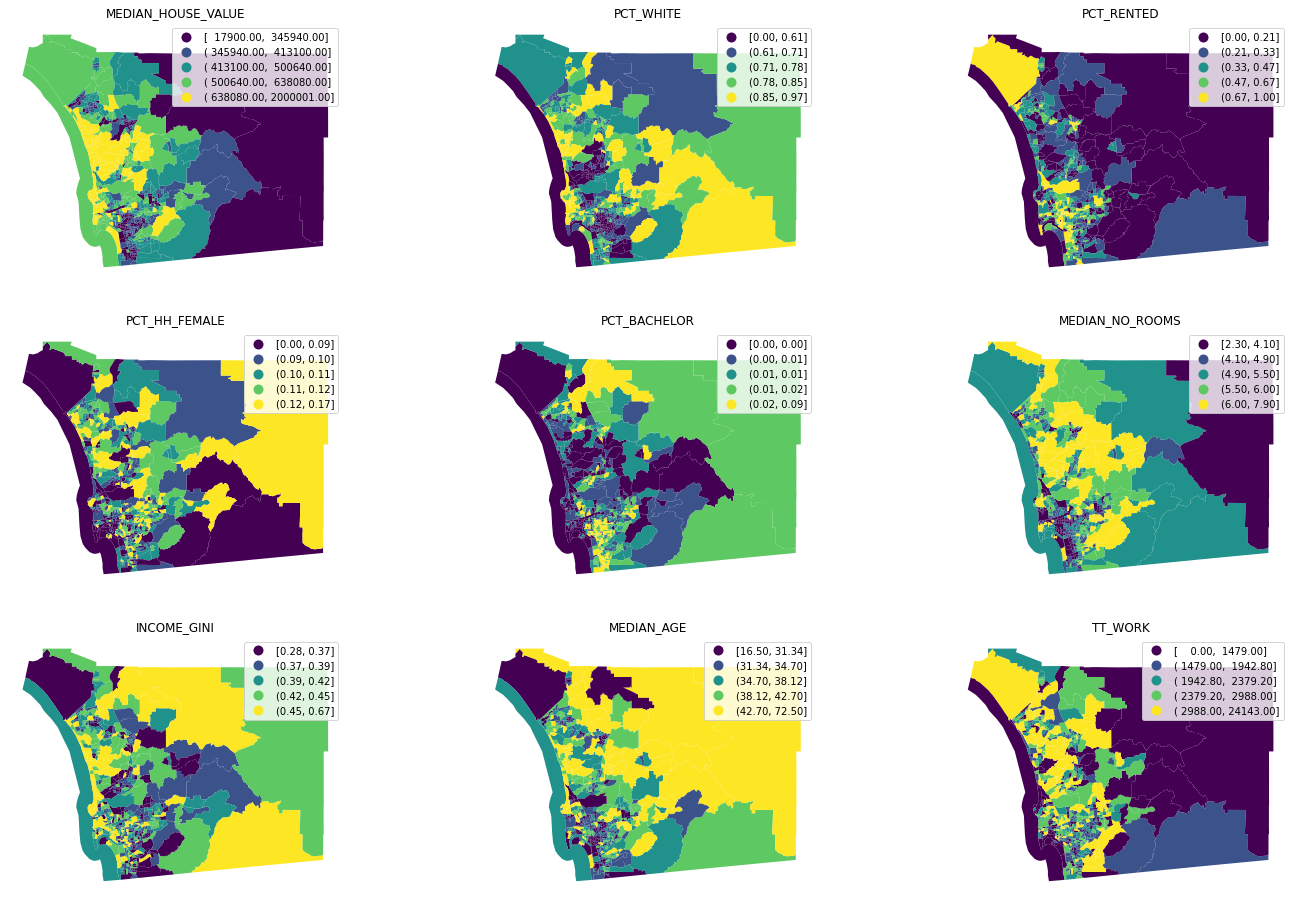

In [47]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 16))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='viridis', legend=True)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col.upper())
# Display the figure
plt.show()

Muchos patrones visuales surgen de los mapas, revelando tanto puntos en común como diferencias entre las distribuciones espaciales de las variables individuales. **Varias variables tienden a aumentar en valor desde el este al oeste** ( pct_rented, median_house_value, median_no_rooms, y tt_work), **mientras que otros tienen una tendencia espacial en la dirección opuesta** ( pct_white, pct_hh_female, pct_bachelor,median_age). Esto es realmente deseable; cuando las variables tienen distribuciones espaciales diferentes, **cada variable aporta información distinta a los perfiles de cada conglomerado**. 

- Sin embargo, **si todas las variables muestran patrones espaciales muy similares, la cantidad de información útil en los mapas es en realidad menor de lo que parece, por lo que los perfiles de conglomerados también pueden ser mucho menos útiles**. 

- **También es importante considerar si las variables muestran alguna autocorrelación espacial, ya que esto afectará la estructura espacial de los conglomerados resultantes**.

    Recuerde del capítulo XXX que la I de Moran es una medida de uso común para la autocorrelación espacial global. Permítanos tener una idea rápida de hasta qué punto esto está presente en nuestro conjunto de datos. Primero, necesitamos construir una matriz de ponderaciones espaciales que codifique las relaciones espaciales en nuestros datos de San Diego. Comenzaremos con la contigüidad de la reina:

In [28]:
w = Queen.from_dataframe(db)

Como hemos visto antes, wno contiene islas:



In [29]:
w.islands

[]

Ahora calculemos el I de Moran para las variables que se utilizan. Esto medirá hasta qué punto cada variable contiene estructura espacial:

In [32]:
# Set seed for reproducibility
numpy.random.seed(123456)

# Calculate Moran's I for each variable
mi_results = [Moran(db[variable], w) for variable in cluster_variables]

# Display on table
table = pandas.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(cluster_variables, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')
table

,Moran's I,P-value
Variable,,
median_house_value,0.646618,0.001
pct_white,0.602079,0.001
pct_rented,0.451372,0.001
pct_hh_female,0.282239,0.001
pct_bachelor,0.433082,0.001
median_no_rooms,0.538996,0.001
income_gini,0.295064,0.001
median_age,0.381440,0.001
tt_work,0.102748,0.001


Cada una de las variables muestra una **autocorrelación espacial positiva significativa**, lo que sugiere que la ley de Tobler está viva y bien en la geografía socioeconómica del condado de San Diego. Esto significa que también debemos esperar que los **grupos que encontremos tengan una distribución espacial no aleatoria**. En particular, esperaríamos que los conglomerados tuvieran una cantidad modesta de coherencia espacial además de la coherencia en sus perfiles, ya que existe una fuerte autocorrelación positiva en todas las variables de entrada.

La autocorrelación espacial solo describe las relaciones entre una sola observación a la vez. Por lo tanto, el hecho de que todas las variables de agrupamiento estén autocorrelacionadas positivamente no nos dice cómo los atributos covarían en el espacio. Para eso, **debemos considerar la correlación espacial entre variables. Aquí, mediremos esto usando la correlación bivariada en los mapas de covariables mismos.**

Dados los 9 mapas, hay 36 pares de mapas que deben compararse. Son demasiados mapas para procesar visualmente, por lo que podemos recurrir a una herramienta alternativa para centrarnos explícitamente en las relaciones bivariadas entre cada par de atributos.

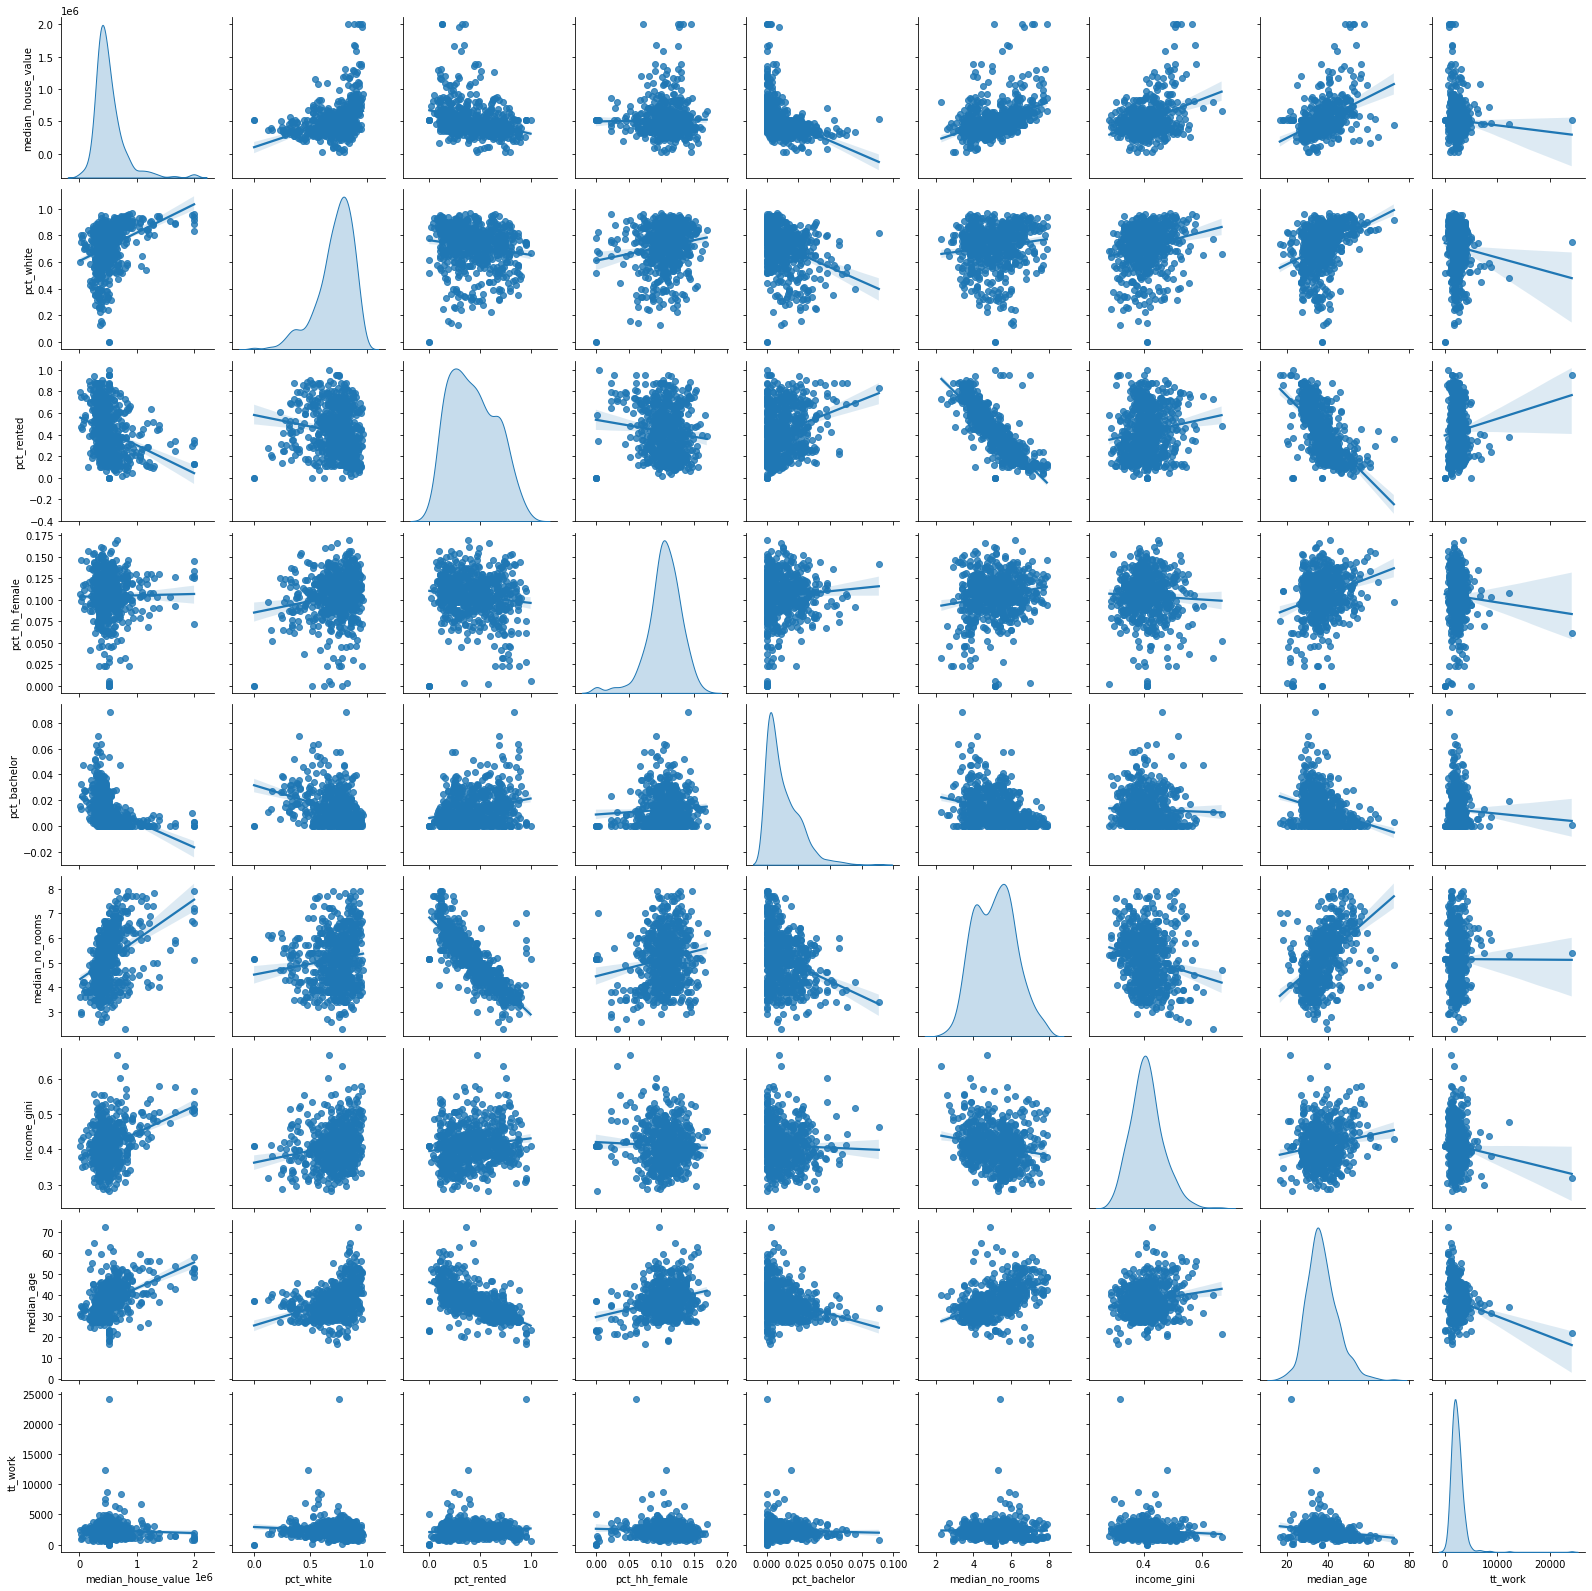

In [33]:
_ = seaborn.pairplot(db[cluster_variables], kind='reg', diag_kind='kde')

La matriz de gráficos de dispersión contiene dos tipos diferentes de gráficos. En la diagonal están las funciones de densidad para los nueve atributos. Estos permiten una inspección de la morfología general de la distribución del valor del atributo. El examen de estas vemos que nuestra selección de variables incluye aquellos que son sesgada negativamente ( pct_whitey pct_hh_female), así como un sesgo positivo ( median_house_value, pct_bachelory tt_work).

El segundo tipo de visualización se encuentra en las celdas fuera de la diagonal de la matriz; estos son diagramas de dispersión bivariados. Cada celda muestra la asociación entre un par de variables. Varias de estas celdas indican asociaciones lineales positivas ( median_ageVs. median_house_value, median_house_valueVs. median_no_rooms) mientras que otras celdas muestran una correlación negativa ( median_house_valueVs. pct_rented, median_no_roomsVs. pct_rentedy median_ageVs. pct_rented). La única variable que tiende a tener una asociación consistentemente débil con las otras variables es tt_work, y en parte esto parece reflejar su distribución bastante concentrada como se ve en la celda de la esquina inferior derecha diagonal.

Comprobamos con la correlación:

In [34]:
db[cluster_variables].corr()

,median_house_value,pct_white,pct_rented,pct_hh_female,pct_bachelor,median_no_rooms,income_gini,median_age,tt_work
median_house_value,1.000000,0.351904,-0.306910,0.016479,-0.408302,0.400470,0.360806,0.443800,-0.053436
pct_white,0.351904,1.000000,-0.153147,0.165994,-0.332744,0.131547,0.196427,0.356475,-0.094359
pct_rented,-0.306910,-0.153147,1.000000,-0.121206,0.266008,-0.820291,0.145876,-0.629762,0.096016
pct_hh_female,0.016479,0.165994,-0.121206,1.000000,0.073479,0.162178,-0.045446,0.261040,-0.051443
pct_bachelor,-0.408302,-0.332744,0.266008,0.073479,1.000000,-0.285147,-0.036688,-0.291012,-0.043689
median_no_rooms,0.400470,0.131547,-0.820291,0.162178,-0.285147,1.000000,-0.191331,0.496774,-0.001918
income_gini,0.360806,0.196427,0.145876,-0.045446,-0.036688,-0.191331,1.000000,0.167503,-0.092688
median_age,0.443800,0.356475,-0.629762,0.261040,-0.291012,0.496774,0.167503,1.000000,-0.182290
tt_work,-0.053436,-0.094359,0.096016,-0.051443,-0.043689,-0.001918,-0.092688,-0.182290,1.000000


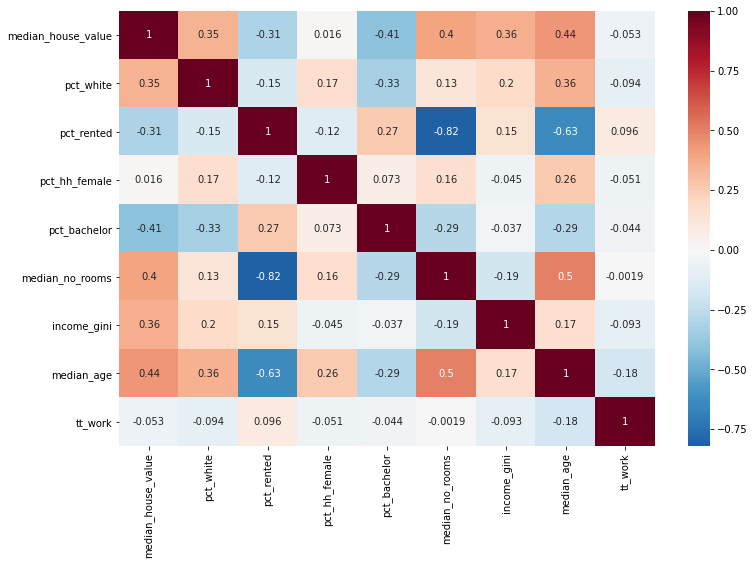

In [45]:
plt.figure(figsize=(12,8))
seaborn.heatmap(db[cluster_variables].corr(),
            center=0,annot=True,cmap='RdBu_r');

## Agrupaciones geodemográficas en las áreas censales de San Diego

Ahora nos moveremos más allá del enfoque implícitamente bivariable para considerar la **naturaleza multidimensional** completa de este conjunto de datos. El análisis geodemográfico es una forma de agrupamiento multivariante donde las observaciones representan áreas geográficas. La salida de estos agrupamientos casi siempre está mapeada. En conjunto, estos métodos utilizan algoritmos de agrupamiento multivariante para construir un número conocido de agrupaciones (k), donde el número de conglomerados suele ser mucho menor que el número de observaciones que se van a agrupar. A cada grupo se le asigna una etiqueta única y estas etiquetas se asignan. Utilizando el perfil y la etiqueta de los conglomerados, el mapa de etiquetas se puede interpretar para tener una idea de la distribución espacial de los rasgos sociodemográficos. El poder de la agrupación (geodemográfica) proviene de tomar la variación estadística en varias dimensiones y comprimirla en una única categórica que podemos visualizar a través de un mapa. Para demostrar la variedad de enfoques en la agrupación, mostraremos dos algoritmos de agrupación distintos pero muy populares: k-means y el método jerárquico de Ward.



### K-means

K-means es probablemente el enfoque más utilizado para agrupar un conjunto de datos. El algoritmo agrupa las observaciones en un número preestablecido de grupos para que cada observación esté más cerca de la media de su propio grupo que de la media de cualquier otro grupo. El problema de k-medias se resuelve iterando entre un paso de asignación y un paso de actualización. Primero, a todas las observaciones se les asigna aleatoriamente una de las k etiquetas. A continuación, se calcula la media multivariada de todas las covariables para cada uno de los conglomerados. Luego, cada observación se reasigna al grupo con la media más cercana. Si la observación ya está asignada al grupo cuya media está más cercana, la observación permanece en ese grupo. Este proceso de actualización de asignaciones continúa hasta que no sean necesarias más reasignaciones.

La naturaleza de este algoritmo requiere que seleccionemos el número de clústeres que queremos crear. En la práctica, se desconoce el número correcto de agrupaciones. Para ilustrar, usaremos k=5 en la KMeans implementación de scikit-learn. Para continuar, primero creamos un KMeans clusterer:

In [48]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

A continuación, llamamos al fit método para aplicar el algoritmo k-means a nuestros datos:



In [49]:
# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db[cluster_variables])

Ahora que se han asignado los conglomerados, podemos examinar el vector de etiqueta, que registra el conglomerado al que se asigna cada observación:

In [50]:
k5cls.labels_

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2,
       3, 1, 4, 0, 1, 1, 1, 4, 1, 4, 1, 4, 4, 1, 0, 4, 4, 4, 1, 4, 4, 1,
       4, 4, 4, 0, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1,
       4, 4, 0, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 4, 0, 4, 0, 4, 4, 0, 1, 1,
       1, 0, 3, 3, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 4, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 4, 1, 4, 2, 4, 0, 4, 4, 4, 4, 1, 4, 4, 1, 0, 4, 4, 4, 4,
       4, 1, 1, 1, 1, 4, 4, 1, 0, 4, 4, 4, 1, 4, 4, 0, 0, 0, 1, 2, 2, 2,
       4, 4, 4, 4, 4, 2, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 3, 1,
       1, 1, 1, 0, 4, 1, 4, 4, 4, 4, 1, 1, 4, 4, 0, 1, 4, 4, 4, 1, 1, 1,
       1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 1,
       1, 4, 1, 4, 1, 1, 0, 4, 0, 4, 0, 3, 4, 1, 2, 0, 4, 1, 1, 4, 2, 1,
       4, 4, 1, 0, 0, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 0, 1, 1, 4,
       4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 0, 0, 4, 4, 1, 4, 4, 4, 1, 0, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 1, 4,

En este caso, las observaciones segunda y tercera se asignan al grupo 4, mientras que las observaciones cuarta y quinta se han colocado en el grupo 0. Es importante tener en cuenta que las etiquetas de números enteros deben verse como una indicación de membresía solamente: las diferencias numéricas entre los los valores de las etiquetas no tienen sentido. Los perfiles de los distintos clústeres deben explorarse más a fondo al observar los valores de cada dimensión.

Pero, antes de hacer eso, hagamos un mapa.

#### Distribución espacial de clústeres 

Una vez obtenidas las etiquetas de los conglomerados, podemos mostrar la distribución espacial de los conglomerados utilizando las etiquetas como categorías en un mapa de coropletas. Esto nos permite captar rápidamente cualquier tipo de patrón espacial que puedan tener los clústeres. Dado que los conglomerados representan áreas con características similares, el mapeo de sus etiquetas permite ver hasta qué punto áreas similares tienden a tener ubicaciones similares. Por lo tanto, esto nos da un mapa que incorpora la información de las nueve covariables.

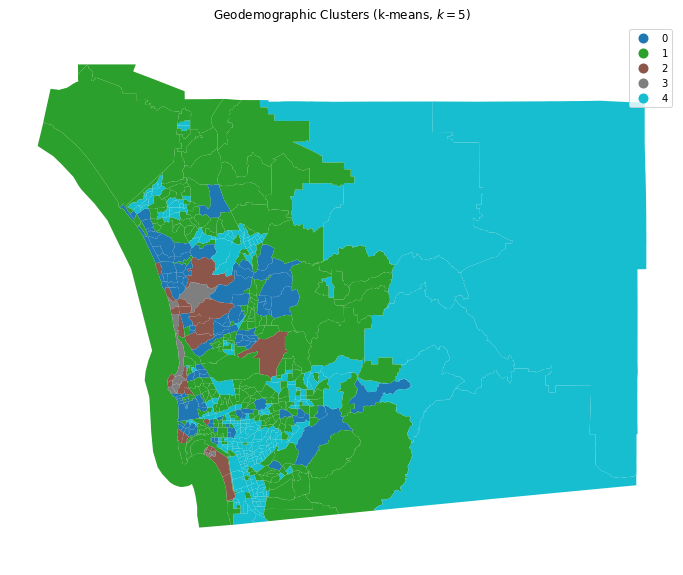

In [62]:
# Assign labels into a column
db['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(12, 10))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Clusters (k-means, $k=5$)')
# Display the map
plt.show()

El mapa proporciona una vista útil de los resultados de la agrupación; permite una inspección visual de la medida en que la primera ley de la geografía de Tobler se refleja en los grupos multivariados. Recuerde que la ley implica que las extensiones cercanas deben ser más similares entre sí que las áreas geográficamente más distantes entre sí. Podemos ver evidencia de esto en nuestro mapa de conglomerados, ya que emergen grupos de extensiones con el mismo color. Sin embargo, esta inspección visual se ve oscurecida por la complejidad de las unidades espaciales subyacentes. Nuestros ojos se dirigen a los polígonos más grandes en la parte oriental del condado, lo que da la impresión de que el grupo 1 es el grupo dominante. Si bien esto parece ser cierto en términos de área de tierra (y lo verificaremos a continuación), hay más en el patrón de conglomerados que esto.


In [108]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
scaler = StandardScaler()
cluster_data = pd.DataFrame(scaler.fit_transform(db[cluster_variables]), columns=cluster_variables)

X = cluster_data#db[cluster_variables]
num_clusters = range(2, 21)
kmeans = [KMeans(n_clusters=i,random_state=1234) for i in num_clusters]
score = [kmeans[i].fit(X).score(X)**2 for i in range(len(kmeans))]

In [109]:
list(num_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

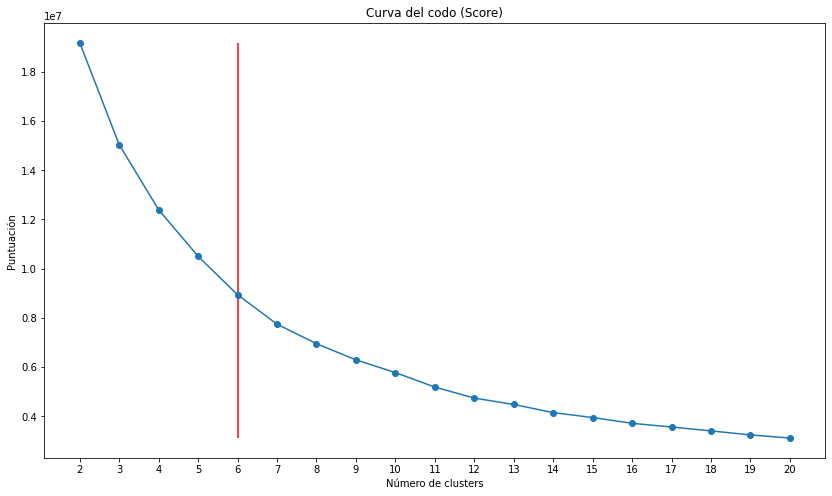

In [110]:
n_clusters = 6

plt.figure(figsize=(14,8))
plt.plot(num_clusters,score,'o-')
plt.vlines(x=n_clusters, ymin=min(score), ymax=max(score), color='r')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación')
plt.xticks(list(num_clusters))
plt.title('Curva del codo (Score)')
plt.show()

In [111]:
from sklearn.metrics import silhouette_score
sil_score = [silhouette_score(X, kmeans[i].fit(X).labels_) for i in range(len(kmeans))]

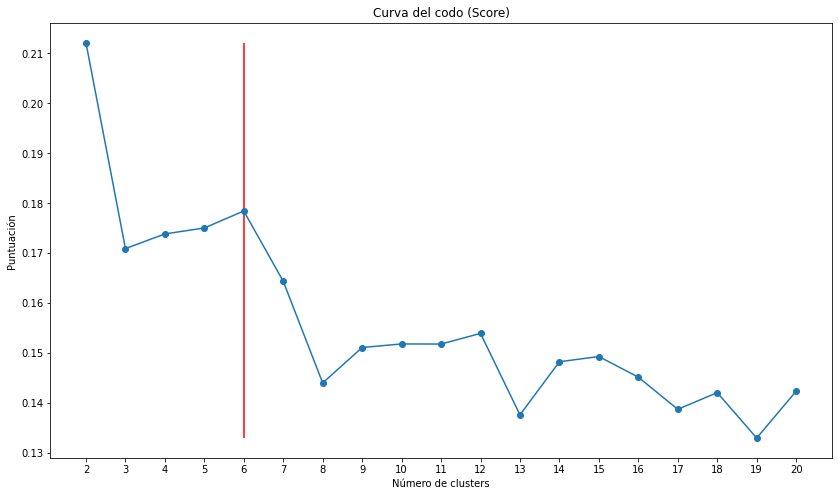

In [112]:
n_clusters = 6

plt.figure(figsize=(14,8))
plt.plot(num_clusters,sil_score,'o-')
plt.vlines(x=n_clusters, ymin=min(sil_score), ymax=max(sil_score), color='r')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación')
plt.xticks(list(num_clusters))
plt.title('Curva del codo (Score)')
plt.show()

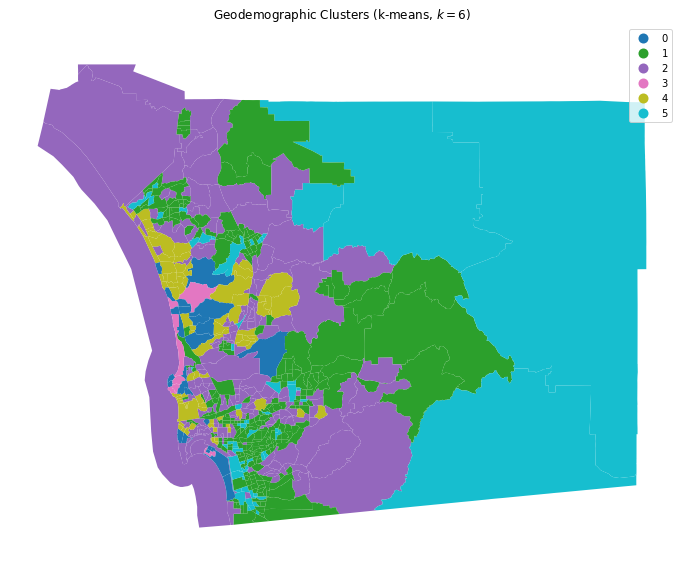

In [114]:
# Initialise KMeans instance
kmeans6 = KMeans(n_clusters=6)

# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
k6cls = kmeans6.fit(db[cluster_variables])

# Assign labels into a column
db['k6cls'] = k6cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(12, 10))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k6cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Clusters (k-means, $k=6$)')
# Display the map
plt.show()


#### Análisis estadístico del mapa de conglomerados
Para complementar la geovisualización de los conglomerados, podemos explorar las propiedades estadísticas del mapa de conglomerados. Este proceso nos permite profundizar en qué observaciones forman parte de cada clúster y cuáles son sus características. Esto nos da el perfil de cada clúster para que podamos interpretar el significado de las etiquetas que hemos obtenido. Podemos comenzar, por ejemplo, considerando la cardinalidad o el recuento de observaciones en cada grupo:

In [115]:
# Group data table by cluster label and count observations
k6sizes = db.groupby('k6cls').size()
k6sizes

k6cls
0     25
1    275
2    178
3      9
4     79
5     62
dtype: int64

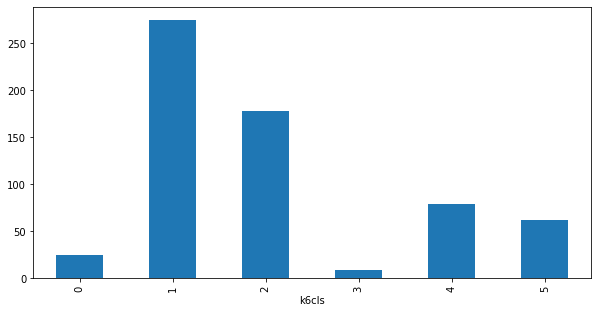

In [116]:
_ = k6sizes.plot.bar()

In [117]:
# Dissolve areas by Cluster, aggregate by summing, and keep column for area
areas = db.dissolve(by='k6cls', aggfunc='sum')['area_sqm']
areas

k6cls
0     245.345027
1    2132.682220
2    3445.101073
3      63.002389
4     383.631949
5    5452.009985
Name: area_sqm, dtype: float64

<AxesSubplot:xlabel='k6cls'>

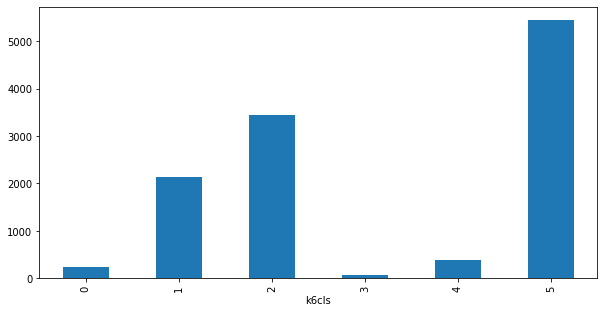

In [118]:
areas.plot.bar()

In [120]:
areas[5]/areas.sum()

0.465118216429044

In [121]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k6means = db.groupby('k6cls')[cluster_variables].mean()
k6means.T.round(3)

k6cls,0,1,2,3,4,5
median_house_value,1168004.000,385724.000,547405.157,1876867.222,765121.519,221448.387
pct_white,0.841,0.682,0.721,0.909,0.815,0.660
pct_rented,0.288,0.466,0.393,0.251,0.325,0.580
pct_hh_female,0.107,0.105,0.100,0.117,0.104,0.113
pct_bachelor,0.002,0.017,0.009,0.002,0.004,0.022
median_no_rooms,6.020,4.892,5.415,6.422,5.690,4.235
income_gini,0.474,0.401,0.405,0.520,0.430,0.404
median_age,44.436,35.045,37.742,50.544,42.109,34.218
tt_work,2182.000,2336.196,2505.893,1237.778,2291.418,2089.565


 Sin embargo, los valores promedio pueden ocultar una gran cantidad de detalles y, en algunos casos, dar impresiones erróneas sobre el tipo de distribución de datos que representan. Para obtener perfiles más detallados, podemos usar el describe comando en pandas, luego de agrupar nuestras observaciones por sus conglomerados:

In [122]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k6desc = db.groupby('k6cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k6desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k6desc.T[cluster].unstack())


	---------
	Cluster 0
                    count          mean            std            min  \
median_house_value   25.0  1.168004e+06  120618.166404  972800.000000   
pct_white            25.0  8.410426e-01       0.109941       0.542849   
pct_rented           25.0  2.875354e-01       0.159089       0.089633   
pct_hh_female        25.0  1.068837e-01       0.017825       0.068381   
pct_bachelor         25.0  2.245429e-03       0.002630       0.000000   
median_no_rooms      25.0  6.020000e+00       1.333229       4.000000   
income_gini          25.0  4.741920e-01       0.042624       0.408200   
median_age           25.0  4.443600e+01       9.200674      24.800000   
tt_work              25.0  2.182000e+03    1321.458790     702.000000   

                             25%           50%           75%           max  
median_house_value  1.068400e+06  1.174600e+06  1.256300e+06  1.391700e+06  
pct_white           8.087572e-01  8.755782e-01  9.118435e-01  9.461056e-01  
pct_rented     

Sin embargo, este enfoque se sale de control rápidamente: **los perfiles más detallados pueden simplemente volver a un lío de números difícil de manejar**. 

**Un mejor enfoque para construir perfiles de conglomerados es dibujar las distribuciones de los datos de los miembros del conglomerado**. Para hacer esto, necesitamos "ordenar" el conjunto de datos. Un conjunto de datos ordenado ( Wickham, 2014 ) es aquel en el que cada fila es una observación y cada columna es una variable. Por lo tanto, se requieren algunos pasos para ordenar nuestros datos etiquetados:

In [124]:
# Index db on cluster ID
tidy_db = db.set_index('k6cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db

,k6cls,Attribute,Values
0,4,median_house_value,732900.000000
1,4,pct_white,0.916988
2,4,pct_rented,0.373913
3,4,pct_hh_female,0.052896
4,4,pct_bachelor,0.000000
...,...,...,...
5647,5,pct_bachelor,0.012997
5648,5,median_no_rooms,4.100000
5649,5,income_gini,0.441600
5650,5,median_age,60.600000


Ahora estamos listos para trazar. A continuación, mostraremos la distribución de los valores de cada grupo para cada variable. Esto nos da el perfil de distribución completo de cada clúster:



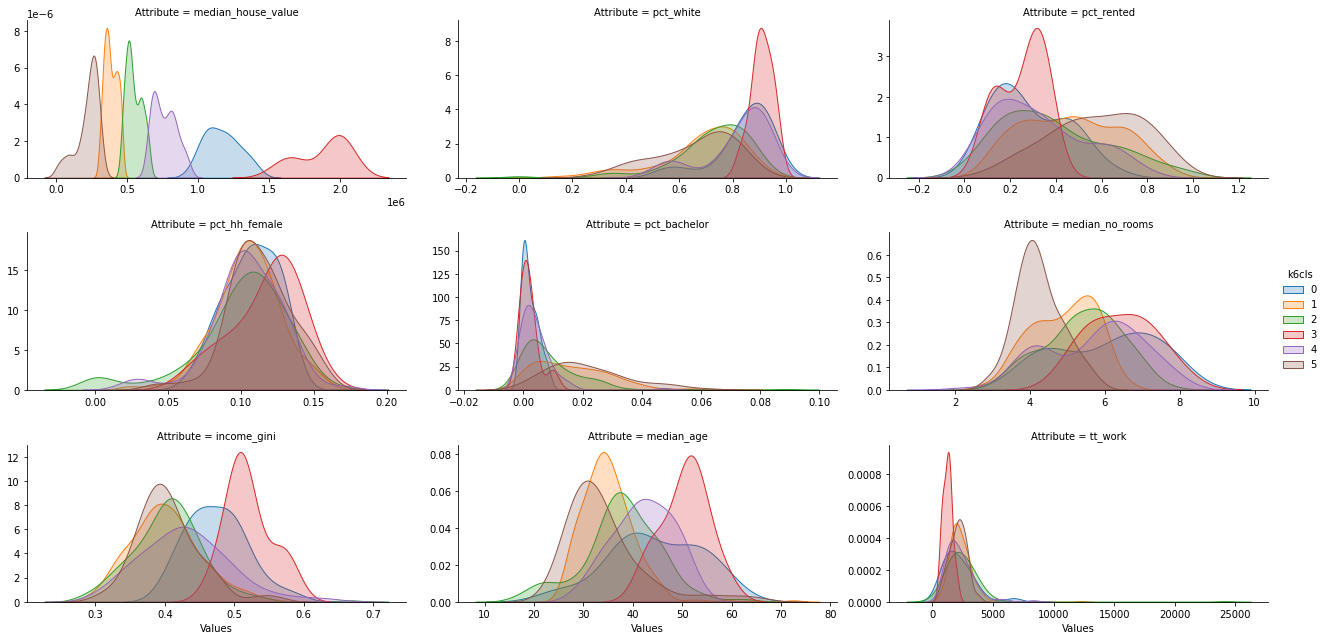

In [128]:
# Setup the facets
facets = sns.FacetGrid(data=tidy_db, col='Attribute', hue='k6cls',
                       sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()

sto nos permite ver que, si bien algunos atributos como el porcentaje de hogares de mujeres ( pct_hh_female) muestran en gran medida la misma distribución para cada grupo, otros muestran una imagen mucho más dividida (por ejemplo median_house_value). Tomados en conjunto, estos gráficos nos permiten comenzar a profundizar en la complejidad multidimensional de cada grupo y los tipos de áreas detrás de ellos.

### Agrupación jerárquica
Como se mencionó anteriormente, k-means es solo un algoritmo de agrupamiento. Hay muchos más. En esta sección, analizaremos de manera similar el conjunto de datos de San Diego utilizando otro elemento básico del conjunto de herramientas de agrupación: **agrupación jerárquica aglomerativa (AHC)**. La agrupación aglomerativa funciona mediante la construcción de una jerarquía de soluciones de agrupación que comienza con todos los elementos únicos (cada observación es un grupo único en sí misma) y termina con todas las observaciones asignadas al mismo grupo. Estos extremos no son muy útiles en sí mismos. Pero, en el medio, la jerarquía contiene muchas soluciones de agrupación distintas con distintos niveles de detalle. La intuición detrás del algoritmo también es bastante sencilla:

1. comience con todos como parte de su propio grupo;

2. encontrar las dos observaciones más cercanas basándose en una métrica de distancia (por ejemplo, euclidiana);

3. únalas en un nuevo grupo;

4. repita los pasos 2) y 3) hasta alcanzar el grado de agregación deseado.

Por lo tanto, el algoritmo **se denomina "aglomerativo" porque comienza con grupos individuales y los "aglomera" en cada vez menos grupos que contienen más y más observaciones cada uno**. Además, al igual que con k-means, AHC requiere que el usuario especifique una cantidad de clústeres por adelantado. Esto se debe a que, siguiendo el mecanismo que tiene el método para construir conglomerados, AHC puede proporcionar una solución con tantos conglomerados como observaciones (k=n), o con uno solo (k=1).

Basta de teoría, ¡empecemos a programar! En Python, AHC se puede ejecutar en scikit-learn de la misma manera que lo hicimos con k-means en la sección anterior. En este caso, usamos la AgglomerativeClustering clase y nuevamente usamos el fi tmétodo para aplicar el algoritmo de agrupamiento en clústeres a nuestros datos:

In [129]:
# Set seed for reproducibility
numpy.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(db[cluster_variables])
# Assign labels to main data table
db['ward5'] =model.labels_

In [130]:
ward5sizes = db.groupby('ward5').size()
ward5sizes

ward5
0    141
1    233
2    222
3     23
4      9
dtype: int64

In [131]:
ward5means = db.groupby('ward5')[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
median_house_value,703765.957,473097.931,316161.712,1184173.913,1876867.222
pct_white,0.799,0.706,0.656,0.842,0.909
pct_rented,0.327,0.420,0.523,0.293,0.251
pct_hh_female,0.105,0.102,0.106,0.107,0.117
pct_bachelor,0.005,0.011,0.021,0.002,0.002
median_no_rooms,5.695,5.222,4.575,5.939,6.422
income_gini,0.421,0.401,0.403,0.478,0.520
median_age,41.535,36.389,34.062,44.261,50.544
tt_work,2305.206,2556.399,2172.563,2201.913,1237.778


In [132]:
# Index db on cluster ID
tidy_db = db.set_index('ward5')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,0,median_house_value,732900.000000
1,0,pct_white,0.916988
2,0,pct_rented,0.373913
3,0,pct_hh_female,0.052896
4,0,pct_bachelor,0.000000


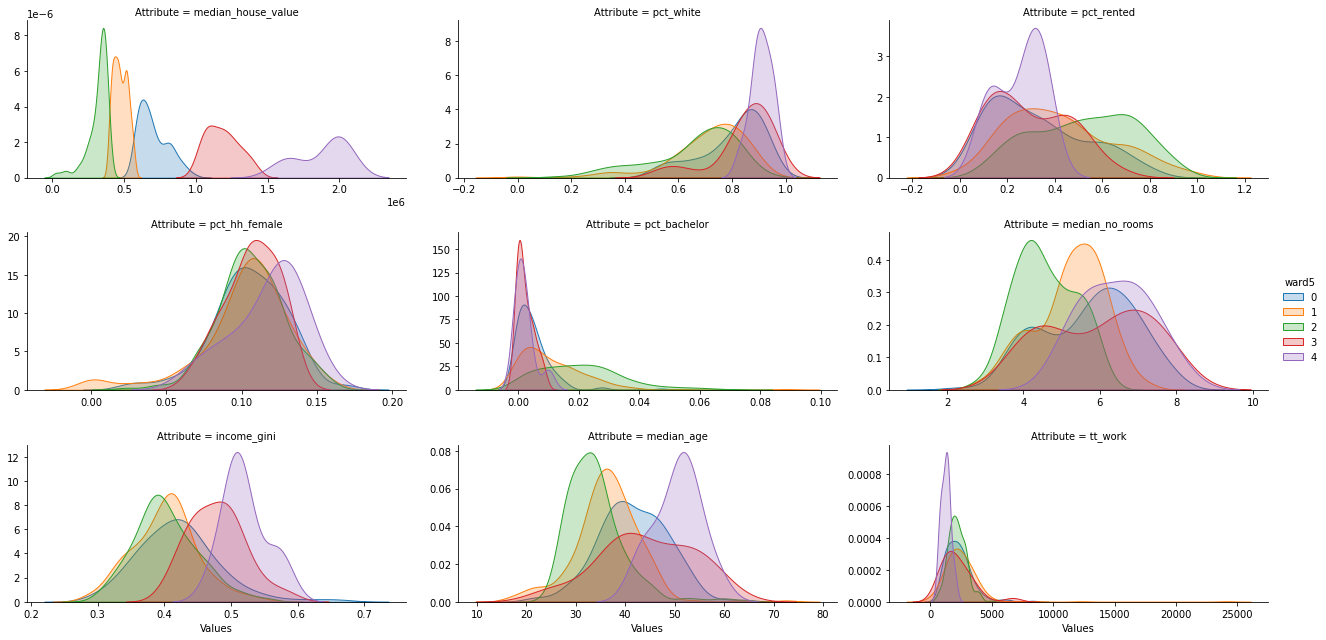

In [133]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='ward5', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

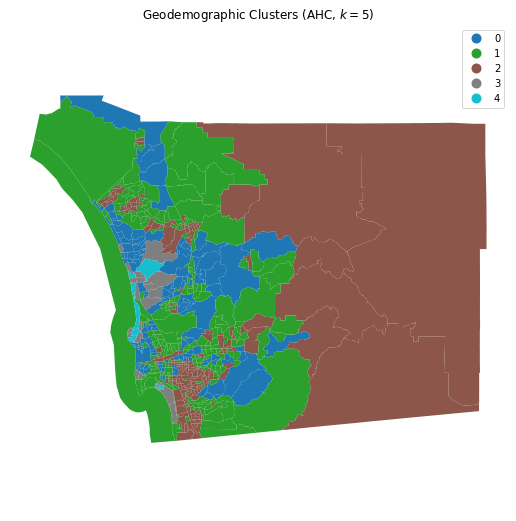

In [134]:
db['ward5'] =model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Clusters (AHC, $k=5$)')
# Display the map
plt.show()

Y, para simplificar las comparaciones, podemos mostrar los resultados k-means y AHC uno al lado del otro:

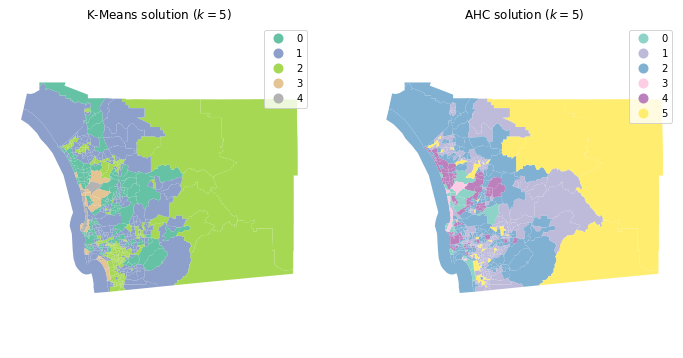

In [135]:
db['ward5'] =model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5', categorical=True, cmap='Set2', 
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('K-Means solution ($k=5$)')

ax = axs[1]
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k5cls', categorical=True, cmap='Set3',
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('AHC solution ($k=5$)')

# Display the map
plt.show()

Si bien debemos recordar nuestra advertencia anterior sobre cómo los polígonos irregulares pueden desconcertar nuestra intuición visual, una inspección visual más cercana de la geografía del cúmulo sugiere un patrón claro: aunque no son idénticos, **ambos conglomerados capturan una estructura espacial general muy similar. **

Además, **ambas soluciones violan levemente la ley de Tobler, ya que todos los grupos tienen componentes desconectados**. Los cinco grupos multivariados en cada caso están compuestos en realidad por muchas áreas geográficas dispares, esparcidas alrededor del mapa de acuerdo solo con la estructura de los datos y no con su geografía. Es decir, para viajar a todos los tramos que pertenecen a un grupo, tendríamos que viajar también a través de otros grupos.


### Agrupación jerárquica restringida espacialmente

Los clústeres fragmentados no son intrínsecamente inválidos, especialmente si estamos interesados en explorar la estructura general y la geografía de los datos multivariados. **Sin embargo, en algunos casos, la aplicación que nos interesa puede requerir que todas las observaciones de una clase estén conectadas espacialmente**. Por ejemplo, cuando se detectan **comunidades o vecindarios** (como a veces es necesario al trazar los límites electorales o censales), casi siempre son áreas autoconectadas distintas, a diferencia de los grupos que se muestran arriba. **Para asegurarnos de que los clústeres no estén fragmentados espacialmente**, recurrimos a la **regionalización**.

Los métodos de regionalización son **técnicas de agrupación que imponen limitaciones espaciales a las agrupaciones**. En otras palabras, el resultado de un algoritmo de regionalización **contiene clusters con áreas geográficamente coherentes**, además de tener perfiles de datos coherentes. Efectivamente, esto significa que los métodos de regionalización construyen agrupaciones que están todas conectadas internamente; estas son las regiones. Por lo tanto, los miembros de una región deben estar anidados geográficamente dentro de los límites de la región.

**Este tipo de relación de anidamiento es fácil de identificar en el mundo real**. Por ejemplo, los **condados** anidan dentro de los estados o, en el Reino Unido, las áreas de superproducción local (LSOA) anidan dentro de las áreas de superproducción media (MSOA). La diferencia entre estos anidamientos del mundo real y el resultado de un algoritmo de regionalización es que **los anidamientos del mundo real se agregan de acuerdo con principios administrativos, pero los miembros de las regiones se agregan de acuerdo con una técnica estadística**. De la misma manera que las técnicas de agrupamiento exploradas anteriormente, **estos métodos de regionalización agregan observaciones que son similares en sus covariables**; los perfiles de regiones son útiles de manera similar a los perfiles de agrupaciones. Pero, en la regionalización, la agrupación también está restringida espacialmente,

**Como en el caso no espacial, existen muchos métodos de regionalización diferentes**. Cada uno tiene una forma diferente de medir la (dis) similitud, cómo se usa la similitud para asignar etiquetas, cómo estas etiquetas se ajustan iterativamente, etc. **Sin embargo, al igual que con los algoritmos de agrupación en clústeres, todos los métodos de regionalización comparten algunos rasgos comunes**. 

En particular, **todos toman un conjunto de atributos de entrada y una representación de la conectividad espacial en forma de una matriz binaria de ponderaciones espaciales**. Dependiendo del algoritmo, también requieren el número deseado de regiones de salida. A modo de ilustración, tomaremos el algoritmo **AHC** que acabamos de usar anteriormente y aplicaremos una restricción espacial adicional. En scikit-learn, esto se hace usando nuestra **matriz de ponderaciones espaciales** como un **connectivity** opción. Esto obligará al algoritmo de aglomeración a permitir que las observaciones solo se agrupen en un clúster si también están conectadas espacialmente:

In [136]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(db[cluster_variables])

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 4016 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

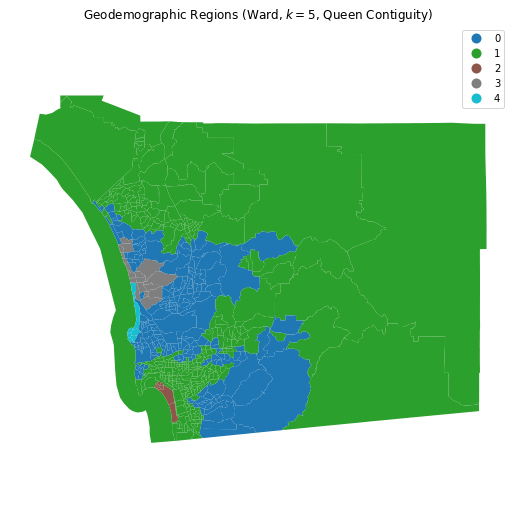

In [137]:
db['ward5wq'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Regions (Ward, $k=5$, Queen Contiguity)')
# Display the map
plt.show()

La introducción de la restricción espacial da como resultado clústeres completamente conectados con distribuciones espaciales mucho más concentradas. A partir de una impresión visual inicial, podría parecer que nuestra restricción espacial ha sido violada: hay tramos tanto para el grupo 0 como para el grupo 1 que parecen estar desconectados del resto de sus grupos. Sin embargo, una inspección más cercana revela que cada uno de estos tramos está conectado a otro tramo en su propio grupo por límites compartidos muy estrechos.



#### Cambiar la restricción espacial

La restricción espacial en los algoritmos de regionalización está estructurada por la matriz de ponderaciones espaciales que utilizamos. Por tanto, una cuestión interesante es cómo influye la elección de los pesos en la estructura final de la región. Afortunadamente, podemos explorar directamente el impacto que tiene un cambio en la matriz de ponderaciones espaciales sobre la regionalización. Para hacerlo, **usamos los mismos datos de atributos pero reemplazamos la matriz de contigüidad de Queen con una matriz espacial de vecino más cercano K**, donde cada observación está conectada a sus cuatro observaciones más cercanas, en lugar de aquellas que toca.

In [146]:
w = KNN.from_dataframe(db, k=4)

In [143]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(db[cluster_variables])

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 2512 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

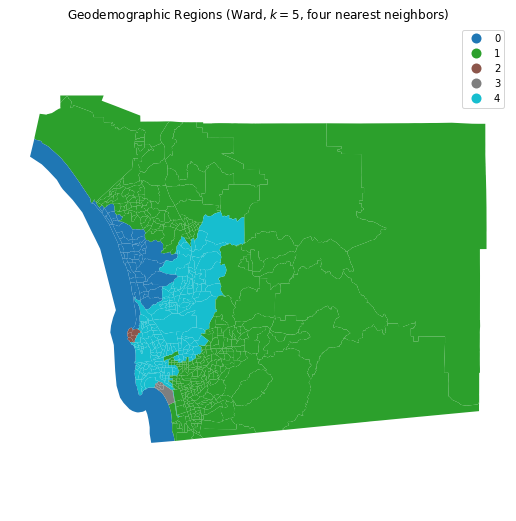

In [144]:
db['ward5wknn'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5wknn', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Regions (Ward, $k=5$, four nearest neighbors)')
# Display the map
plt.show()

Aunque hemos especificado una restricción espacial, **la restricción se aplica al gráfico de conectividad modelado por nuestra matriz de ponderaciones**. Por lo tanto, el uso de k vecinos más cercanos para restringir la agrupación aglomerativa puede no dar como resultado regiones que estén conectadas de acuerdo con una regla de conectividad diferente, como la regla de contigüidad de la reina utilizada en la sección anterior. Sin embargo, la regionalización aquí es fortuita; a pesar de que usamos los 4 tramos más cercanos para restringir la conectividad, todos menos uno de los grupos, el grupo 4, también están conectados de acuerdo con nuestra regla anterior de contigüidad de reinas.

A primera vista, esto puede parecer contrario a la intuición. Especificamos la restricción espacial, por lo que nuestra reacción inicial es que se viola la restricción de conectividad. Sin embargo, este no es el caso, ya que la restricción se aplica al gráfico del vecino más cercano k, no al gráfico de contigüidad de la reina. Por lo tanto, **dado que las áreas de esta solución se consideran conectadas a sus cuatro vecinos más cercanos, los clústeres pueden "saltar" unos sobre otros**. Por lo tanto, **es importante reconocer que la aparente estructura espacial de las regionalizaciones dependerá de cómo se modele la conectividad de las observaciones.**

### Realizando la búsqueda a través de silhouette

**Proximidad de la reina**

In [183]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
scaler = StandardScaler()
cluster_data = pd.DataFrame(scaler.fit_transform(db[cluster_variables]), columns=cluster_variables)

X = cluster_data#db[cluster_variables]
num_clusters = range(2, 21)

w_queen = Queen.from_dataframe(db)

ahc = [AgglomerativeClustering(linkage='ward',connectivity=w_queen.sparse,n_clusters=i) for i in num_clusters]

sil_score = [silhouette_score(X, ahc[i].fit(X).labels_) for i in range(len(ahc))]

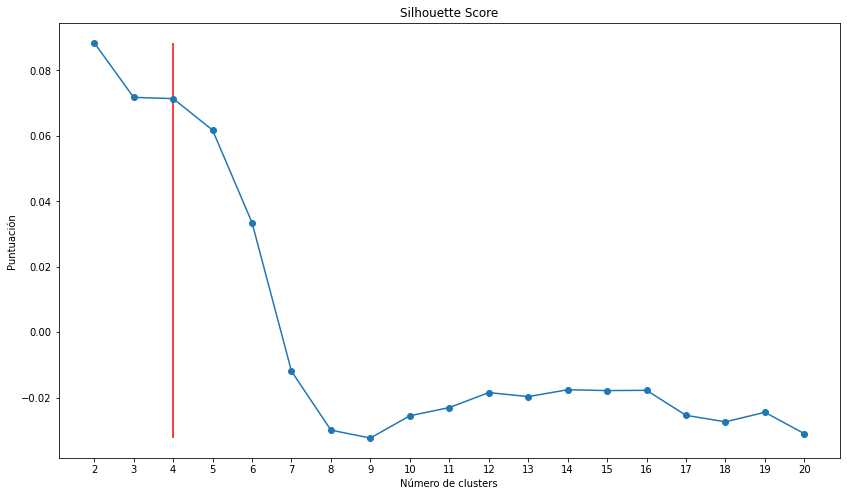

In [184]:
n_clusters = 4

plt.figure(figsize=(14,8))
plt.plot(num_clusters,sil_score,'o-')
plt.vlines(x=n_clusters, ymin=min(sil_score), ymax=max(sil_score), color='r')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación')
plt.xticks(list(num_clusters))
plt.title('Silhouette Score')
plt.show()

In [185]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                connectivity=w_queen.sparse,
                                n_clusters=4)
model.fit(X)

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 4016 stored elements in Compressed Sparse Row format>,
                        n_clusters=4)

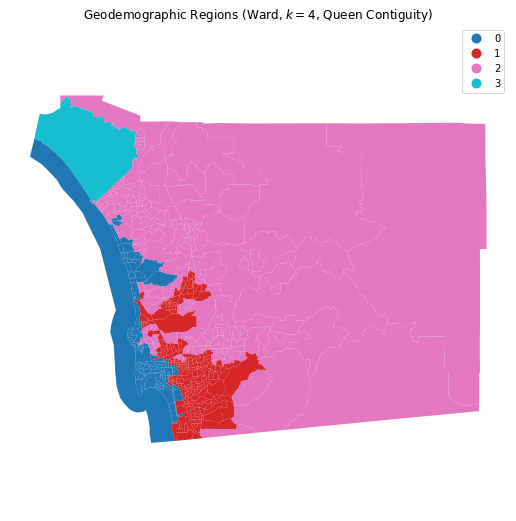

In [186]:
db['ward4wq'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward4wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Regions (Ward, $k=4$, Queen Contiguity)')
# Display the map
plt.show()

**KNN(k=4)**

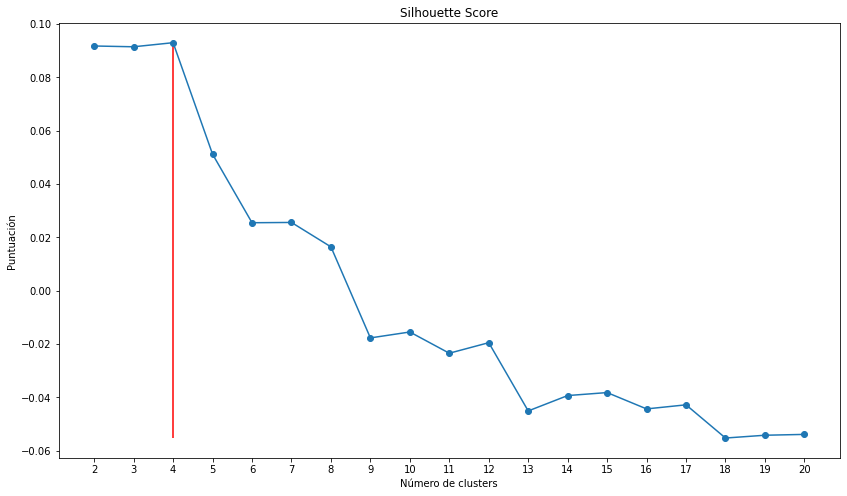

In [187]:
w_KNN = KNN.from_dataframe(db, k=4)

ahc_KNN = [AgglomerativeClustering(linkage='ward',connectivity=w_KNN.sparse,n_clusters=i) for i in num_clusters]

sil_score_KNN = [silhouette_score(X, ahc_KNN[i].fit(X).labels_) for i in range(len(ahc))]

n_clusters = 4

plt.figure(figsize=(14,8))
plt.plot(num_clusters,sil_score_KNN,'o-')
plt.vlines(x=n_clusters, ymin=min(sil_score_KNN), ymax=max(sil_score_KNN), color='r')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación')
plt.xticks(list(num_clusters))
plt.title('Silhouette Score')
plt.show()

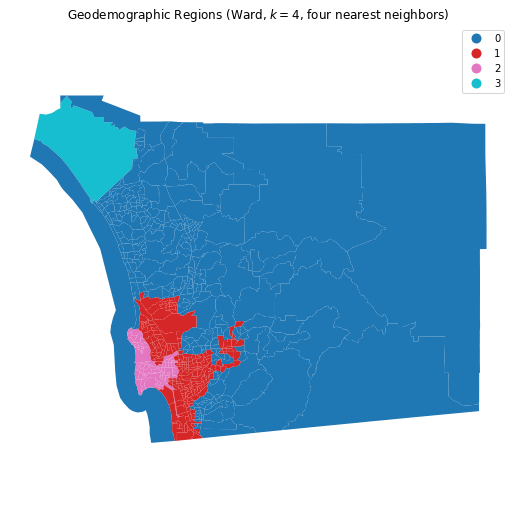

In [189]:
numpy.random.seed(123456)
model_KNN = AgglomerativeClustering(linkage='ward',
                                connectivity=w_KNN.sparse,
                                n_clusters=n_clusters)
model_KNN.fit(X)

db['ward4wq_KNN'] = model_KNN.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward4wq_KNN', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Regions (Ward, $k=4$, four nearest neighbors)')
# Display the map
plt.show()

## Conclusión

En general, la agrupación en clústeres y la regionalización son dos herramientas complementarias para reducir la complejidad de los datos multivariados y construir una mejor comprensión de la estructura espacial de los datos. A menudo, simplemente hay demasiados datos para examinar cada mapa de variables y su relación con todos los demás mapas de variables. Por lo tanto, la agrupación reduce esta complejidad a una única taquigrafía conceptual mediante la cual las personas pueden describir fácilmente datos complejos y multifacéticos. La agrupación construye grupos de observaciones (llamados agrupaciones ) con perfiles coherentes, o características distributivas / descriptivas distintas e internamente consistentes. Estos perfiles son la abreviatura conceptual, ya que los miembros de cada grupo deberían ser más similares al grupo en general que a cualquier otro grupo. Existen muchos métodos de agrupación diferentes; difieren en cómo se define el "grupo en general" y en qué tan "similares" deben ser los miembros a los grupos, o cómo se obtienen estos grupos. La regionalización es un tipo especial de agrupación con un requisito geográfico adicional. Las observaciones deben agruparse de modo que cada grupo espacial o región, es espacialmente coherente y coherente con los datos. Por lo tanto, la regionalización a menudo se ocupa de la conectividad en un gráfico de contigüidad para los datos recopilados en áreas; esto asegura que las regiones identificadas estén completamente conectadas internamente. Sin embargo, dado que muchos métodos de regionalización se definen para una estructura de conectividad arbitraria, estos gráficos también se pueden construir de acuerdo con diferentes reglas, como el gráfico del vecino más cercano k.

En este capítulo, discutimos la base conceptual para la agrupación y la regionalización, además de mostrar por qué se realiza la agrupación. Además, hemos mostrado cómo construir clústeres usando paquetes de ciencia de datos espaciales y cómo interrogar el significado de estos clústeres también. De manera más general, los conglomerados se utilizan a menudo en entornos predictivos y explicativos, además de utilizarse para el análisis exploratorio por derecho propio. La agrupación en clústeres y la regionalización también están íntimamente relacionados con el análisis de la autocorrelación espacial, ya que la estructura espacial y la covariación en los datos espaciales multivariados es lo que determina la estructura espacial y el perfil de datos de los clústeres o regiones descubiertos. Por lo tanto, la agrupación y la regionalización son herramientas esenciales para el científico de datos espaciales.